# Чтение данных

In [1]:
import pandas as pd
import os

In [2]:
SEED = 21
PATH = '../data'

In [3]:
df_train = pd.read_csv(os.path.join(PATH, 'train.csv'))
df_val = pd.read_csv(os.path.join(PATH, 'val.csv'))
df_test = pd.read_csv(os.path.join(PATH, 'test.csv'))

In [4]:
def norm_form(list_words, morph):
    return [morph.parse(word)[0].normal_form for word in list_words]

def del_stopwords(list_words, stop_words):
    return [word for word in list_words if word not in stop_words]

def transform_data(df):
    df = df.copy()
    df['level_2'] = df['icd10'].str.split('.').apply(lambda x: x[0])
    df['level_1'] = df['icd10'].apply(lambda x: x[0])
    return df

In [5]:
clms = ['symptoms', 'level_2']
dic_rename = {'symptoms': 'text', 'level_2': 'label'}

df_train = transform_data(df_train)[clms].rename(dic_rename, axis=1)
df_val = transform_data(df_val)[clms].rename(dic_rename, axis=1)
df_test = transform_data(df_test)[clms].rename(dic_rename, axis=1)

In [6]:
i2l = dict(enumerate(sorted(df_train['label'].unique())))
l2i = {label: i for i, label in i2l.items()}
na_i = max(i2l.keys()) + 1

y_train = df_train['label'].map(l2i).values
y_val = df_val['label'].map(l2i).fillna(na_i).values
y_test = df_test['label'].map(l2i).fillna(na_i).values

X_train = df_train['text'].values
X_val = df_val['text'].values
X_text = df_test['text'].values

# Пример получения эмбеддингов

In [7]:
# from transformers import AutoTokenizer, AutoModel
# import torch


# #Mean Pooling - Take attention mask into account for correct averaging
# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output[0] #First element of model_output contains all token embeddings
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# # Sentences we want sentence embeddings for
# sentences = ['This is an example sentence', 'Each sentence is converted']

# # Load model from HuggingFace Hub
# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
# model = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

# # Tokenize sentences
# encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# # Compute token embeddings
# with torch.no_grad():
#     model_output = model(**encoded_input)

# # Perform pooling. In this case, max pooling.
# sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# print("Sentence embeddings:")
# print(sentence_embeddings)

In [8]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import random

import torch
from torch import nn, Tensor
from typing import Iterable, Dict


from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
from torch.optim import AdamW
from matplotlib import pyplot as plt

from IPython.display import clear_output
import gc


In [9]:
# tokenizer.decode(encoded_input.input_ids[0])

In [10]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)

In [11]:
class TextDataset(Dataset):
    def __init__(self, tokenizer, sentences, labels, max_length=128):
        self.len = len(sentences)
        self.data = tokenizer.batch_encode_plus(
            list(sentences), 
            padding=True, 
            truncation=True, 
            return_tensors='pt', 
            max_length=max_length
        )
        self.data['labels'] = torch.tensor(labels)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):        
        return dict(
            input_ids=self.data['input_ids'][idx],
            attention_mask=self.data['attention_mask'][idx],
            labels=self.data['labels'][idx]
        )


class Body(torch.nn.Module):
    def __init__(self, model):
        super(Body, self).__init__()
        self.model = model
        
    @staticmethod
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, encoded_input):
        model_output = self.model(
            input_ids=encoded_input['input_ids'], 
            attention_mask=encoded_input['attention_mask'],
        )
        encoded_input['sentence_embedding'] = self.mean_pooling(model_output, encoded_input['attention_mask'])
        return encoded_input
    
    
class CosineSimilarityLoss(nn.Module):
    def __init__(self, model, loss_fct=nn.MSELoss(), cos_score_transformation=nn.Identity()):
        super(CosineSimilarityLoss, self).__init__()
        self.model = model
        self.loss_fct = loss_fct
        self.cos_score_transformation = cos_score_transformation

    def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):
        embeddings = [self.model(sentence_feature)['sentence_embedding'] for sentence_feature in sentence_features]
        output = self.cos_score_transformation(torch.cosine_similarity(embeddings[0], embeddings[1]))
        return self.loss_fct(output, labels.view(-1))

In [12]:
def sentence_pairs_generation(dataset, batch_size = 128):
    labels = ds_train[:]['labels']
    
    labels_uniq = np.unique(labels)
    label_to_idx = {x: i for i, x in enumerate(labels_uniq)}
    positive_idxs = [np.where(labels == i)[0] for i in labels_uniq]
    negative_idxs = [np.where(labels != i)[0] for i in labels_uniq]

    idxs1, idxs2, new_labels = [], [], []
    for label in np.random.choice(labels_uniq, int(batch_size/2), replace=True):
        first_idx = np.random.choice(positive_idxs[label_to_idx[label]])
        current_sentence = dataset[first_idx]

        idxs = positive_idxs[label_to_idx[label]]
        if len(idxs) > 1:
            idxs = idxs[idxs != first_idx] 
            second_idx = np.random.choice(idxs)
            idxs1.append(first_idx)
            idxs2.append(second_idx)
            new_labels.append(1.0)

        idxs = negative_idxs[label_to_idx[label]]
        third_idx = np.random.choice(idxs)
        idxs1.append(first_idx)
        idxs2.append(third_idx)
        new_labels.append(0.0)
        
    sentence_features = (dataset[idxs1], dataset[idxs2])
    return sentence_features, torch.tensor(new_labels)


def batch_generator(sentences, batch_size):
    n_samples = len(sentences)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        yield sentences[start:end]
        
def get_embeddings(model, dataset, batch_size):
    embeddings = []
    generator = batch_generator(dataset, batch_size)
    total = int(np.ceil(len(dataset) / batch_size))
    for dataset_batch in tqdm(generator, total=total):
        dataset_batch['input_ids'] = dataset_batch['input_ids'].to(device)
        dataset_batch['attention_mask'] = dataset_batch['attention_mask'].to(device)
        with torch.no_grad():        
            embeddings.append(model(dataset_batch)['sentence_embedding'].cpu().numpy())
    embeddings = np.vstack(embeddings)
    embeddings = np.vstack(embeddings)
    
    return embeddings

def hit_at_n(y_true, y_pred, n=3):
    assert len(y_true) == len(y_pred)
    
    score = np.mean(np.any(
        np.argsort(-y_pred, axis=1)[:, :n] == y_true.reshape(-1,1), 
        axis=1
    ))
    return score



def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [13]:
class ModelCheckpoint:
    """Save the model after every epoch.
    `filepath` can contain named formatting options,
    which will be filled the value of `epoch` and `val_loss`.
    For example: if `filepath` is `weights.{epoch:02d}-{val_loss:.2f}.hdf5`,
    then the model checkpoints will be saved with the epoch number and
    the validation loss in the filename.
    # Arguments
        model: PyTorch model object
        filepath: string, path to save the model file.
        save_best_only: if `save_best_only=True`,
            the latest best model according to
            the quantity monitored will not be overwritten.
        mode: one of {min, max}.
            If `save_best_only=True`, the decision
            to overwrite the current save file is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc.
        save_weights_only: if True, then only the model's weights will be
            saved, else the full model is saved.
    """

    def __init__(
        self,
        model: torch.nn.Module,
        filepath: str,
        mode: str = "min",
        save_best_only: bool = True,
        save_weights_only: bool = False,
    ):
        self.model = model
        self.filepath = filepath
        self.mode = mode
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.num_saves = 0

        if mode == "min":
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == "max":
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            raise ValueError("mode " + mode + " is unknown!")

        Path(self.filepath).parent.mkdir(exist_ok=True, parents=True)

    def _save_model(self):
        if self.save_weights_only:
            torch.save(self.model.state_dict(), self.filepath)
        else:
            torch.save(self.model, self.filepath)
        self.num_saves += 1

    def step(self, current, epoch=None):
        if isinstance(current, torch.Tensor):
            current = current.cpu()
        if self.save_best_only:
            if self.monitor_op(current, self.best):
                self.best = current
                self._save_model()
        else:
            self._save_model()

In [ ]:
model_checkpoint = ModelCheckpoint(model, 'models/cointegrated_rubert_tiny2.pt', mode="max")

In [14]:
# clear_cache()

In [15]:
device = 'cuda'

In [16]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
model_base = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

In [17]:
model_body = Body(model_base).to(device)
model_loss = CosineSimilarityLoss(model_body).to(device)
# criterion = CosineSimilarityLoss()
# criterion = criterion.to(device)


In [18]:
ds_train = TextDataset(tokenizer, X_train, y_train, max_length=64)
ds_val = TextDataset(tokenizer, X_val, y_val, max_length=64)

{'train_loss': 0.07917346682399512, 'score_train': 0.7189507494646681, 'score_val': 0.5693069306930693}


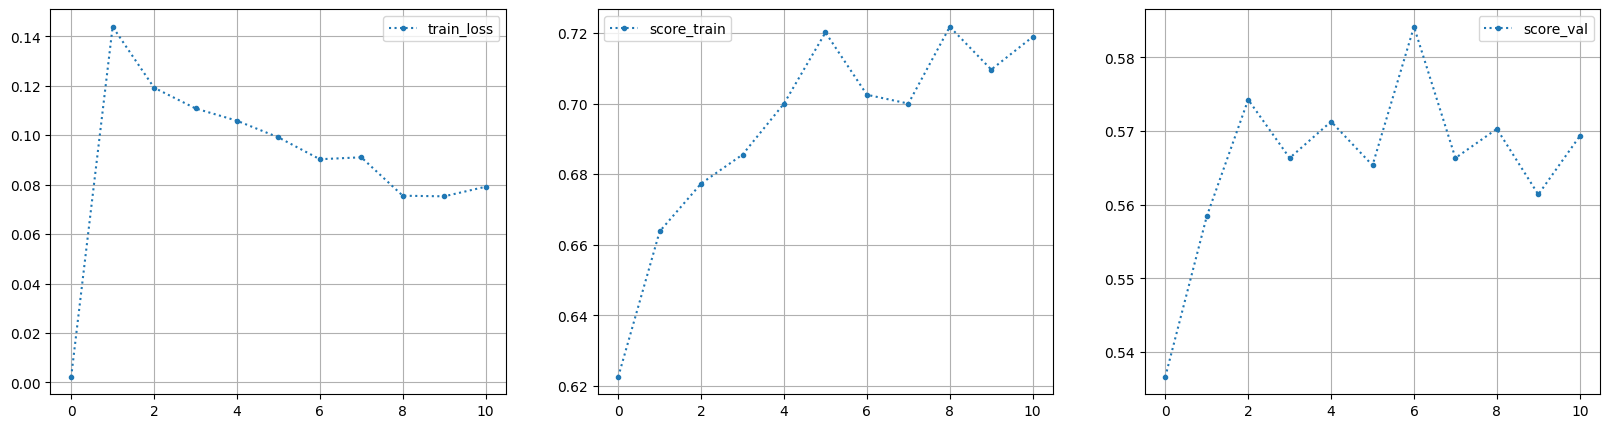

/home/dima/anaconda3/envs/setfit/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/dima/anaconda3/envs/setfit/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

KeyboardInterrupt: 

In [19]:
model = model_loss

lr = 0.0000125  # usually from 1e-5 until 8e-5
# warmup_steps = 50
# num_steps = 12000

optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=lr, weight_decay=0
)


# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_steps)


num_steps = 10000
global_step = 0
tr_loss, logging_loss = 0.0, 0.0
gradient_accumulation_steps = 1
batch_size = 16
max_grad_norm = 1
logging_steps = 100  # периодичность проверки качества модели, чтобы во время остановить обучение

result = []
for step in range(num_steps):
    sentence_features, labels = sentence_pairs_generation(ds_train, batch_size)
    
    sentence_features[0]['input_ids'] = sentence_features[0]['input_ids'].to(device)
    sentence_features[0]['attention_mask'] = sentence_features[0]['attention_mask'].to(device)
    sentence_features[1]['input_ids'] = sentence_features[1]['input_ids'].to(device)
    sentence_features[1]['attention_mask'] = sentence_features[1]['attention_mask'].to(device)
    labels = labels.to(device)
    
    model.train()
    
    loss = model(sentence_features, labels)
    
    if gradient_accumulation_steps > 1:
        loss = loss / gradient_accumulation_steps

    loss.backward()
    
    nn.utils.clip_grad_norm_(model_loss.parameters(), max_grad_norm)

    tr_loss += loss.item()

    if (step + 1) % gradient_accumulation_steps == 0:
        optimizer.step()
        # scheduler.step()  # Update learning rate schedule
        model.zero_grad()
        
    if step % logging_steps == 0 or step == 0:
        emb_train = get_embeddings(model_body, ds_train, batch_size=64)
        emb_val = get_embeddings(model_body, ds_val, batch_size=64)

        clf = LogisticRegression(penalty='l2', C=1, multi_class='ovr', n_jobs=-1)
        clf.fit(emb_train, y_train)
        predict_train = clf.predict_proba(emb_train)
        predict_val = clf.predict_proba(emb_val)

        result.append(dict(
            train_loss=tr_loss if step == 0 else (tr_loss - logging_loss) / logging_steps,
            score_train = hit_at_n(y_train, predict_train, n=3),
            score_val = hit_at_n(y_val, predict_val, n=3),
        ))
        logging_loss = tr_loss
        
        clear_output()
        print(result[-1])
        df_result = pd.DataFrame(result)
        fig, axis = plt.subplots(1,3, figsize=(20,5))
        for ax, col in zip(axis, df_result.columns):
            df_result[[col]].plot(style=':.', grid=True, ax=ax)
        plt.show()
        
        # model_checkpoint.step(results["val_hit3"])